# 在上一篇文章中介绍了VGG网络结构，VGG在2014年ImageNet 中获得了定位任务第1名和分类任务第2名的好成绩，而同年分类任务的第一名则是GoogleNet 。GoogleNet是Google研发的深度网络结构，之所以叫“GoogLeNet”，是为了向“LeNet”致敬
与VGGNet模型相比较，GoogleNet模型的网络深度已经达到了22层（ 如果只计算有参数的层，GoogleNet网络有22层深 ，算上池化层有27层），而且在网络架构中引入了Inception单元，从而进一步提升模型整体的性能。虽然深度达到了22层，但大小却比AlexNet和VGG小很多，GoogleNet参数为500万个（ 5M ），VGG16参数是138M，是GoogleNet的27倍多，而VGG16参数量则是AlexNet的两倍多。

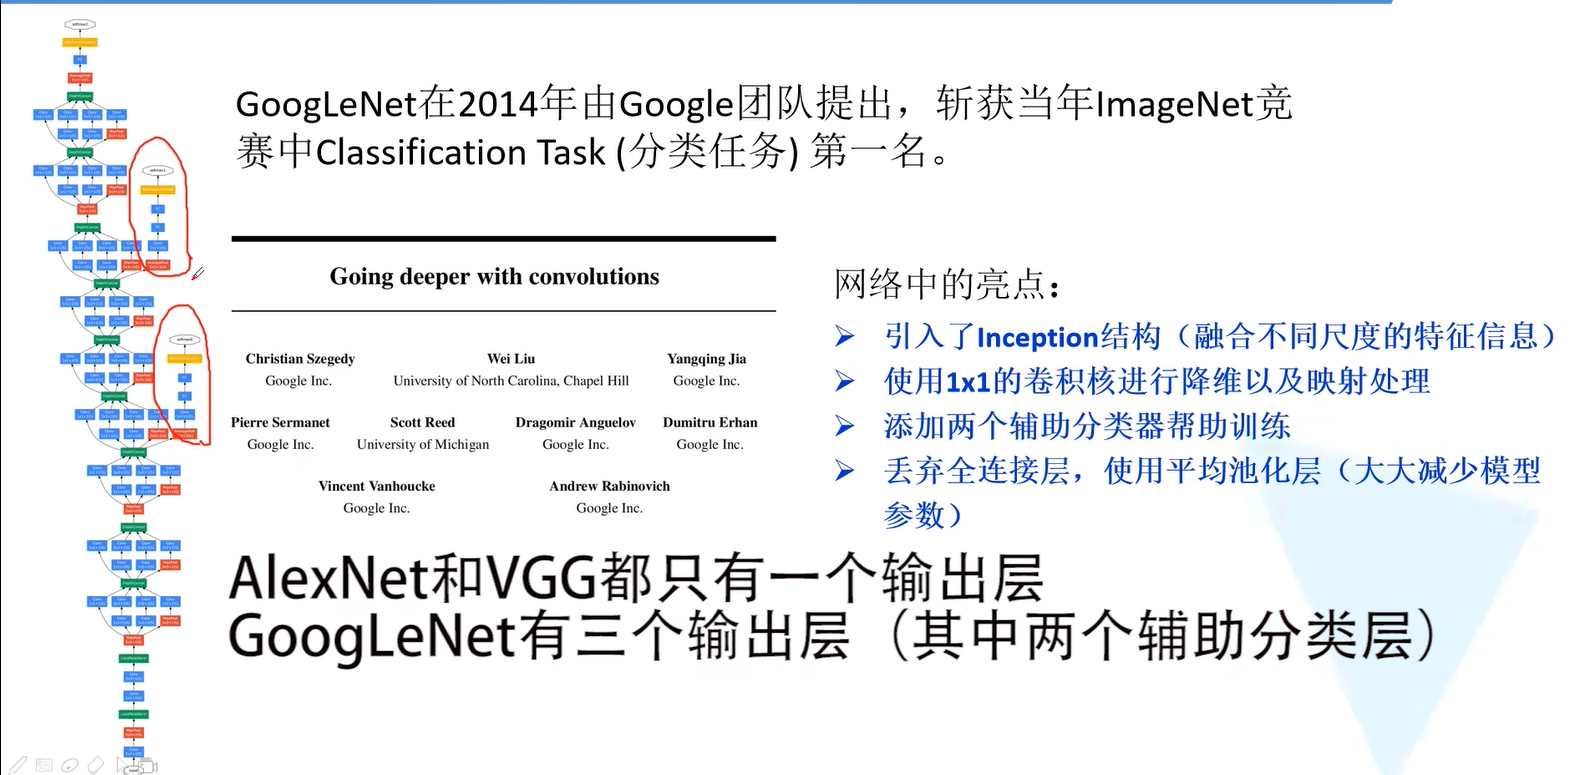

# 搭建GooLeNet模型

In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F


class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True, init_weights=False):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True) #ceil_mode=True向上取整   ceil_mode=False向下取整

        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        if self.training and self.aux_logits:   # eval model lose this layer
            return x, aux2, aux1
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

#Inception模块---------------------------------------------------------------------------------------
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)   # 保证输出大小等于输入大小
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            # 在官方的实现中，其实是3x3的kernel并不是5x5，这里我也懒得改了，具体可以参考下面的issue
            # Please see https://github.com/pytorch/vision/issues/906 for details.
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)   # 保证输出大小等于输入大小
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

#InceptionAux 模块(分类器)---------------------------------------------------------------------------------------
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)  # output[batch, 128, 4, 4]

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14 ,   aux2: N x 528 x 14 x 14
        x = self.averagePool(x)
        # aux1: N x 512 x 4 x 4 ,   aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        return x

#卷积+relu操作的模板
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x


# 模型训练

In [3]:
import os
import sys
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
from tqdm import tqdm




device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

image_path =  "../data/flower_data"
train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                     transform=data_transform["train"])
train_num = len(train_dataset)

# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in flower_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

batch_size = 32
# nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
# print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)

validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=0)

print("using {} images for training, {} images for validation.".format(train_num,
                                                                       val_num))

# test_data_iter = iter(validate_loader)
# test_image, test_label = test_data_iter.next()

net = GoogLeNet(num_classes=5, aux_logits=True, init_weights=True)
# 如果要使用官方的预训练权重，注意是将权重载入官方的模型，不是我们自己实现的模型
# 官方的模型中使用了bn层以及改了一些参数，不能混用
# import torchvision
# net = torchvision.models.googlenet(num_classes=5)
# model_dict = net.state_dict()
# # 预训练权重下载地址: https://download.pytorch.org/models/googlenet-1378be20.pth
# pretrain_model = torch.load("googlenet.pth")
# del_list = ["aux1.fc2.weight", "aux1.fc2.bias",
#             "aux2.fc2.weight", "aux2.fc2.bias",
#             "fc.weight", "fc.bias"]
# pretrain_dict = {k: v for k, v in pretrain_model.items() if k not in del_list}
# model_dict.update(pretrain_dict)
# net.load_state_dict(model_dict)
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0003)

epochs = 10
best_acc = 0.0
save_path = './googleNet.pth'
train_steps = len(train_loader)
for epoch in range(epochs):
    # train
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        logits, aux_logits2, aux_logits1 = net(images.to(device))
        loss0 = loss_function(logits, labels.to(device))
        loss1 = loss_function(aux_logits1, labels.to(device))
        loss2 = loss_function(aux_logits2, labels.to(device))
        loss = loss0 + loss1 * 0.3 + loss2 * 0.3
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 loss)

    # validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        val_bar = tqdm(validate_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))  # eval model only have last output layer
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

    val_accurate = acc / val_num
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)

print('Finished Training')

using cuda:0 device.
using 3306 images for training, 364 images for validation.
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.99it/s]
[epoch 1] train_loss: 3.395  val_accuracy: 0.563
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.01it/s]
[epoch 2] train_loss: 1.824  val_accuracy: 0.569
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.86it/s]
[epoch 3] train_loss: 1.565  val_accuracy: 0.659
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.05it/s]
[epoch 4] train_loss: 1.484  val_accuracy: 0.596
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.89it/s]
[epoch 5] train_loss: 1.412  val_accuracy: 0.690
100%|██████████████████████████████████████████████████████████████████████

# 预测

class: daisy        prob: 0.213
class: dandelion    prob: 0.413
class: roses        prob: 0.148
class: sunflowers   prob: 0.0713
class: tulips       prob: 0.155


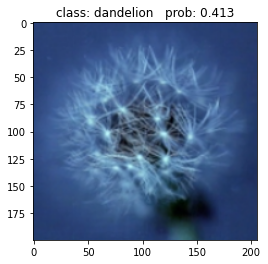

In [4]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load image
img_path = "./1.jpg"
img = Image.open(img_path).convert('RGB')
plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

# read class_indict
json_path = './class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

with open(json_path, "r") as f:
    class_indict = json.load(f)

# create model
model = GoogLeNet(num_classes=5, aux_logits=False).to(device)

# load model weights
weights_path = "./googleNet.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
missing_keys, unexpected_keys = model.load_state_dict(torch.load(weights_path, map_location=device),
                                                      strict=False)

model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                             predict[predict_cla].numpy())
plt.title(print_res)
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                              predict[i].numpy()))
plt.show()


